# IndieP: Predicting the Success of Indie Games on Steam

# Part 2: Data Cleaning

<div align="center"><img src="./data_cleaning.jpeg", title="Image from becominghuman.ai", width="50%"/></div>

In [Part 1](https://github.com/argwood/IndieP/blob/master/IndieP_Data_Collection.ipynb) of this project, we collected a dataset of roughly 22,700 Indie Games including information about the games themselves, collected using the Steam Storefront API, as well as popularity data such as ratings and number of users, collected using the SteamSpy API. The data we collected so far, however, is a bit of a mess and in no way suited for data exploration let alone any machine learning algorithms. We have columns with missing data, columns with json objects embedded inside of them, columns of long markdown text, different ways of handling missing data (0's versus NaNs), and more. Thus, the process of cleaning up our data to be usable and look presentable will be crucial to the next phases of this project. 

As a number of Steam game datasets exist already on [Kaggle](https://www.kaggle.com/nikdavis/steam-store-games), I tried not to be influenced by their decisions on how each clean feature should look - though of course, in many places, there's only one "best" way to do things.

## 2. Data Cleaning

**The goal of the second part of this project is to take the messy datasets we created in Part 1, and transform them into one dataset that is presentable, usable, easy to read, and contains only the columns that we are interested in for the later stages of the project.** As mentioned previously, we ultimately want to discover what features have the greatest effect on the success of a game, and thus the features we will focus on include qualities of the games themselves (price, genres, game descriptions, number of achievements, etc), and metrics that may be useful for quantifying sucess, such as ratings, number of users, and number of copies purchased. 

We will begin this part of the project by taking a look at the data we collected, and making sure our list of AppIDs matches the AppIDs in the full dataset (ensuring we didn't miss any or make any API requests twice, when collecting the data). We will decide how to handle the AppIDs that weren't found by the API, and then investigate other missing data. From here, we will perform transformations on the columns that are messy or have mixed datatypes, and then finally combine the two datasets from the Steam API and SteamSpy API into one table. In Part 4, we will apply some final data transformations on alphanumerical features to prepare them for input to machine learning algorithms, but otherwise at the end of this section we will obtain our final dataset to be used for the remainder of this project.

In general, for data cleaning, we'll want to consider how to deal with the following types of scenarios:
1. **Missing Values:** We can either choose to remove full columns (features) with too much missing data, remove full rows (games) with too much missing data, or fill the data in by using averages or regression. We can also transform columns with a lot of missing data into `Yes/No` columns indicating whether this feature exists (we will do this for DLC/packages, later) 
2. **Special Values:** Make sure that special characters such as infinity, NA and NaN are handled uniformly and won't be part of any future calculations upon those features. Additionally, we'll make sure all prices are formatted uniformly.
3. **Text Formatting:** Remove messy markdown text from features that include long pieces of text. We'll also reformat columns of json objects into cleaner lists.
4. **Outliers**: Check for outliers, and decide based on the feature, type, etc, if they should be kept or removed.
5. **Inconsistencies**: Look for inconsistencies such as negative prices, release dates in the future but `coming_soon` listed as false, `is_free` listed as true but a price provided in `price_overview`, etc. 

### 2.0 Useful Resources for Data Cleaning

Most of my knowledge of data cleaning comes from a class I took at the University of Chicago, but here are some additional resources I used for Part 2 of this project.

1. Intro to Data Engineering - University of Chicago, Dept. of Computer Science (2019)
2. [The Ultimate Guide to Data Cleaning](https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4)
3. [Daniel Bourke's Guide to Exploratory Data Analysis](https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184)
3. [Becoming Human: AI Article on Data Cleaning](https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7)
4. [Data Science Workbook by Daniel Martinez](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb)

### 2.1 Initial Investigation of Missing Data for Steam Dataset

In [72]:
import csv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

pd.set_option("max_columns", 1000)

We can start by taking a look at the first few rows of both datasets, to get a feel for what we're dealing with. Even in the first few rows, we can see missing data, messy markdown and html formatting, and json objects embedded inside columns. After seeing how much data we're missing, we'll then go column-by-column to clean up each of these issues.

In [30]:
data_steam = pd.read_csv('./data/steam_data.csv')
data_steamspy = pd.read_csv('./data/steamspy_data.csv')

In [31]:
data_steam.head(2)

,type,name,steam_appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,movies,achievements,release_date,background,content_descriptors
0,game,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","[{'id': 256744684, 'name': 'V0.3', 'thumbnail'...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"
1,game,- Arcane Raise -,603750,0.0,False,"<img src=""https://steamcdn-a.akamaihd.net/stea...",Arcane Raise is a role-playing video game fran...,English<strong>*</strong><br><strong>*</strong...,https://steamcdn-a.akamaihd.net/steam/apps/603...,NaN,['Arcane Raise'],['WAX Publishing'],"{'currency': 'USD', 'initial': 299, 'final': 2...",[158866],"[{'name': 'default', 'title': 'Buy - Arcane Ra...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","[{'id': 256680620, 'name': 'Arcane Raise - Lau...","{'total': 37, 'highlighted': [{'name': 'Letter...","{'coming_soon': False, 'date': 'Mar 10, 2017'}",https://steamcdn-a.akamaihd.net/steam/apps/603...,"{'ids': [], 'notes': None}"


As the first step to dealing with missing data, the's a really nice python package called Missingno that lets you visualize how many missing data points are in each column of data:

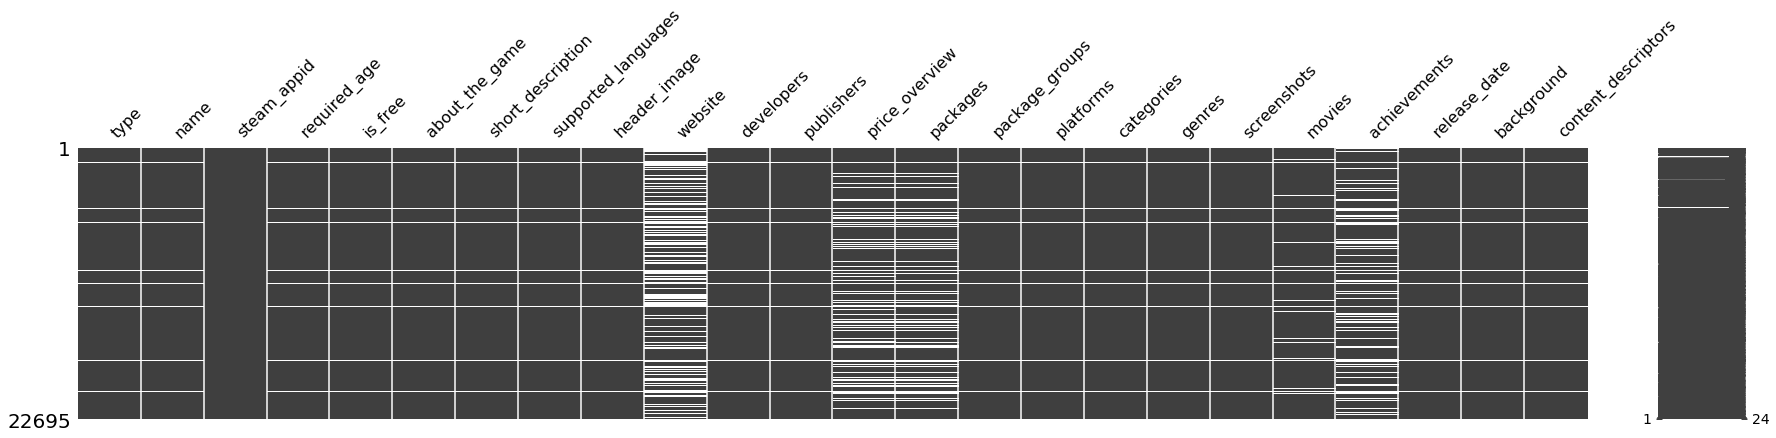

In [33]:
missingno.matrix(data_steam, figsize = (30,5))

The black areas represent existing data, while the white is data that is missing. We can see right off the bat the the columns `website`, `price_overview`, `packages`, and `achievements` have the most missing values.`Movies` has some data missing as well. On the contrary, `steam_appid` has no missing values, since we guaranteed this column to be filled in during our data collection. The full rows with missing data (apart from `steam_appid`) are likely Steam API requests that came back with no result, and thus only the `steam_appid` was entered.

**We need to decide whether or not to keep the sparse columns and rows:** at first glance, `website` might not influence the success of a game, although one could argue that having better marketing and internet presence would make a game better-known. `Price_overview` is likely sparse due to the fact that free games have this column blank - we definitely want to keep this column, but will need to transform it to take into account the free games. `Packages` provides AppIDs for any DLC or additional media, if present, and is blank if there is none - we want to keep this as well, although it's less important than the pricing, because perhaps games with more content are more popular. However, we aren't interested in the exact AppIDs for the packages, so we'll transform this column later into a simple "Yes/No" column. We'll do something similar for `achievements`, which specifies the number of achievements each game has, and fill in the missing values with 0's (i.e., no achievements).  

For now, let's keep all of the columns except for `movies`, which probably isn't too useful, and we aren't planning to do in-depth image analysis with movies (we may for the still images, though).

In [34]:
cols_to_delete = ['movies']
data_steam.drop(columns=cols_to_delete, inplace=True)

Next, we want to remove all of the rows of AppIDs that were not found by the Steam API - since this is only a small portion of our dataset, it shouldn't be a problem to just get rid of them rather than try to find out why they failed the API requests. We can keep a list of the AppIDs we're deleting, in case we want to investigate later to get more data. 

The easiest way to take care of this is to remove all rows where `type` is blank. While we're at it, we want to remove any "non-game" apps that accidentally slipped through our filters (turns out, there's one soundtrack and two DLCs that we don't want).

In [35]:
data_steam['type'].value_counts(dropna=False)

game     21967
NaN        725
dlc          2
music        1
Name: type, dtype: int64

In [36]:
print('Number of blank rows to remove:', data_steam[data_steam['type'].isnull()].shape[0])
data_steam_noAPIresponse = data_steam[data_steam['type'].isnull()]['steam_appid'] #save the deleted appids to a new list just in case
data_steam_noAPIresponse.head(3)

Number of blank rows to remove: 725


36    628340
58    951090
81    841860
Name: steam_appid, dtype: int64

In [37]:
data_steam = data_steam[data_steam.type == 'game'] #only keep rows where type='game'

In [38]:
data_steam['type'].value_counts(dropna=False)

game    21967
Name: type, dtype: int64

Now that we've removed some of the rows we don't want, we can take a look at our Missingno matrix again before we tackle the rest of the cleaning column-by-column:

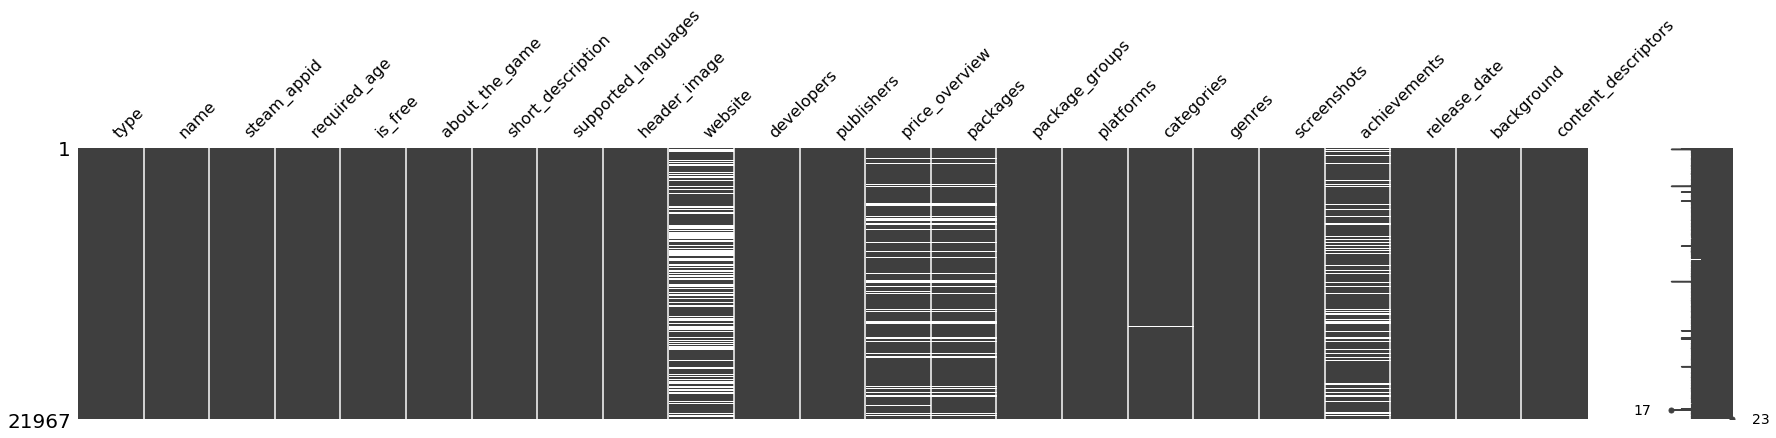

In [40]:
missingno.matrix(data_steam, figsize = (30,5))

It looks much better already! There's something going on with `categories`, though, that we'll deal with later.

Finally, before we move on, we want to check for duplicate rows, as we did at the beginning of Part 1.

In [42]:
data_steam[data_steam.duplicated(subset='steam_appid')]

,type,name,steam_appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors


Awesome, no duplicates!

### 2.2 Steam Dataset: Feature Cleaning

Now that we've removed the rows and columns we're sure we don't want (though of course, we may change our minds later), we'll go through the columns of the dataset one-by-one and clean up the data as well as improve the readability of their labels in some cases.

### Feature 1: Type

Since we've already removed all the rows that have a `type` other than "game", this column is now entirely unneccessary. We can just remove it.

In [43]:
data_steam.drop('type', axis=1, inplace=True)

In [55]:
data_steam.head(1)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"


### Feature 2: Name

There's not a whole lot to be done for the `name` feature, as it sort of is what it is - a name. There's no guarantee that all of the names are unique, or that they are all in English (though we filtered to only include games that are playable in English, the titles aren't required to be). For example, there are three games named "Fireflies", and only one out of the first 7 games in our dataset has a title that is entirely alphanumeric:

In [52]:
data_steam['name'].value_counts(dropna=False).head(7)

Fireflies      3
Exodus         3
The Tower      3
Surge          3
Dark Matter    3
Lost           3
Squares        2
Name: name, dtype: int64

In [51]:
data_steam['name'].str.isalnum().head(7)

0    False
1    False
2    False
3     True
4    False
5    False
6    False
Name: name, dtype: bool

### Feature 3: AppID 

Like `name`, the `steam_appid` is pretty standardized, and we've already filtered out the duplicates. One thing we'll do is rename the column to `appid` since "steam" is redundant.

In [53]:
data_steam.rename(columns={'steam_appid':'appid'},inplace=True)

In [56]:
data_steam.head(1)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"


While we're at it, let's also sort the dataframe by AppID - this will help us combine this dataset with the SteamSpy dataset later on, and also improves readability overall.

In [59]:
data_steam.sort_values(by=['appid'], inplace=True)
data_steam = data_steam.reset_index(drop=True)

In [61]:
data_steam.head(5)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,Rag Doll Kung Fu,1002,0.0,False,Featuring a wide collection of single and mult...,Featuring a wide collection of single and mult...,English,https://steamcdn-a.akamaihd.net/steam/apps/100...,http://www.ragdollkungfu.com/,['Mark Healey'],['Mark Healey'],"{'currency': 'USD', 'initial': 999, 'final': 9...",[45],"[{'name': 'default', 'title': 'Buy Rag Doll Ku...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '23', 'description': 'Indie'}]","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Oct 12, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/100...,"{'ids': [], 'notes': None}"
1,Darwinia,1500,0.0,False,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,"English, German",https://steamcdn-a.akamaihd.net/steam/apps/150...,http://www.darwinia.co.uk/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[54, 14324, 978, 14002]","[{'name': 'default', 'title': 'Buy Darwinia', ...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Jul 14, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/150...,"{'ids': [], 'notes': None}"
2,Uplink,1510,0.0,False,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,English,https://steamcdn-a.akamaihd.net/steam/apps/151...,http://www.uplink.co.uk/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[112, 14002]","[{'name': 'default', 'title': 'Buy Uplink', 'd...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Aug 23, 2006'}",https://steamcdn-a.akamaihd.net/steam/apps/151...,"{'ids': [], 'notes': None}"
3,DEFCON,1520,0.0,False,"Inspired by the 1983 cult classic film, Wargam...","Inspired by the 1983 cult classic film, Wargam...","English, French, German, Italian, Spanish - Spain",https://steamcdn-a.akamaihd.net/steam/apps/152...,http://www.everybody-dies.com/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[156, 14325, 14002]","[{'name': 'default', 'title': 'Buy DEFCON', 'd...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","{'total': 22, 'highlighted': [{'name': 'Victor...","{'coming_soon': False, 'date': 'Sep 29, 2006'}",https://steamcdn-a.akamaihd.net/steam/apps/152...,"{'ids': [], 'notes': None}"
4,Multiwinia,1530,0.0,False,&quot;Long ago a computer scientist called Dr ...,&quot;Long ago a computer scientist called Dr ...,"English, French, Italian, German, Spanish - Spain",https://steamcdn-a.akamaihd.net/steam/apps/153...,http://www.introversion.co.uk/multiwinia/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[1002, 978, 14002]","[{'name': 'default', 'title': 'Buy Multiwinia'...","{'windows': True, 'mac': True, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '23', 'description': 'Indie'}]","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","{'total': 12, 'highlighted': [{'name': 'Domina...","{'coming_soon': False, 'date': 'Sep 19, 2008'}",https://st

### Feature 4: Required Age

Like the previous features we've looked at so far, the `age` column doesn't require too much work. There's no missing values, but we can see that a large majority of the data is `0` - there's no real way to tell if the developers meant that there really is no age restriction, or that they didn't supply this info and just put 0. Regardless, we can get a sense that this category might not be particularly useful, since only 1.5% of the data in this column is non-zero.

In [62]:
data_steam['required_age'].describe()

count    21967.000000
mean         0.221514
std          1.887051
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: required_age, dtype: float64

In [66]:
data_steam['required_age'].value_counts(dropna=False).sort_index()

0.0     21659
3.0         4
6.0         1
7.0         2
10.0       12
11.0        1
12.0       14
13.0       41
14.0        2
15.0        2
16.0       24
17.0      132
18.0       72
20.0        1
Name: required_age, dtype: int64

One thing that we can do to clean up this feature is apply some binning, so that there are fewer categories with only 1 or 2 items in them. Following the suggestion of Nik Davis, we can use a video game rating system to bin the ages into rating categories. Although video game rating systems vary widely throughout the world, In the United States the common rating system is the [ESRB](https://www.esrb.org/ratings-guide/) ratings, for example the commonly-seen "rated E for everyone." Following the description of each rating categories, we can break up our data into the following bins:

* **Everyone:** Ages 0+
* **Everyone 10+:** Ages 10+
* **Teen:** Ages 13+
* **Mature:** Ages 17+
* **Adults:** Ages 18+

In [96]:
def bin_age(df):
    'Bin the age requirements to fit into 5 categories consistent with ESRB rating system'
    
    bins = [-1, 0, 10, 13, 17, 30]
    labels = [0, 10, 13, 17, 18]
    df['required_age']=pd.cut(df['required_age'], bins = bins, labels = labels)
    return df

In [99]:
data_steam = bin_age(data_steam)

We can use the Python plotting package Seaborn to nicely visualize our bins. This is something we'll do throughout this project as we go through our remaining features. In doing so, we find that the large majority of data in this column is still 0, but with fewer bins the data becomes a lot more useful and nicer to visualize.

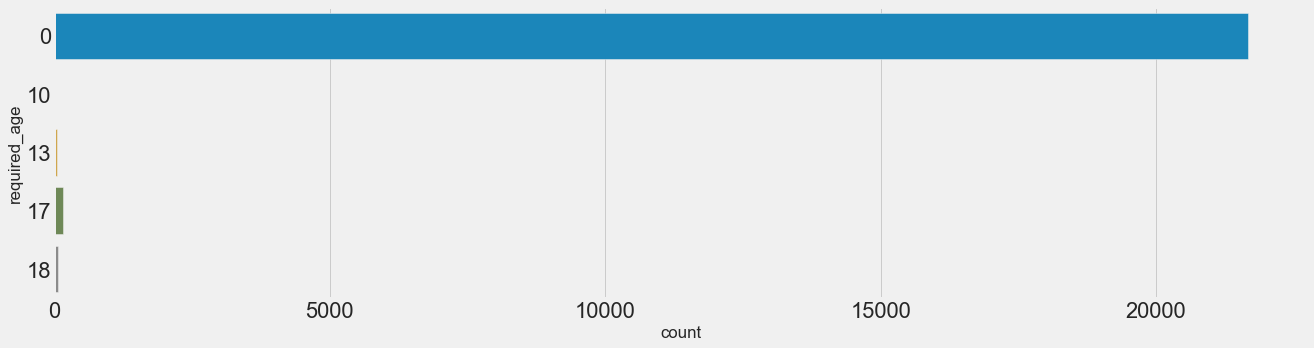

In [100]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="required_age", data=data_steam);

### Feature 5: Is_Free

The `is_free` category is somewhat redundant, as we also have a category that specifically gives the price (with free games listed as 0). However, it may prove useful to keep a binary feature of whether or not a game is free - especially with Indie games, free games could be of very different quality than games that have pricetags (and especially considering Indie games are cheaper overall compared to games from more established companies that can be upwards of $100). 

For this category, the first thing we'll do is take a look at how many games are free versus paid:

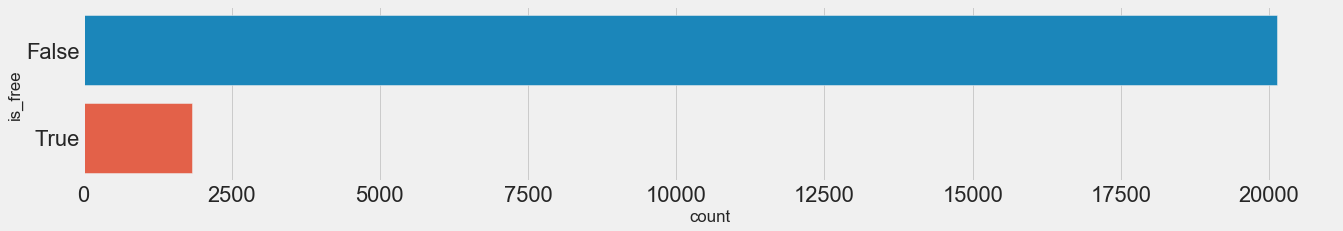

In [102]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,3)) 
sns.countplot(y="is_free", data=data_steam);